In [2]:
import sys
sys.path.append('../')

In [3]:
device='cuda'

In [4]:
import torch
from tqdm import tqdm
from matrix_initializers import SparseMatrixInitializer
from clean_scaffold import GridHippocampalScaffold
from vectorhash import build_initializer
import matplotlib.pyplot as plt
import numpy as np

In [5]:
def corrupt_pcont(pflip, ptrue):
    if pflip == 0:
        return ptrue
    pinit = ptrue + pflip * torch.randn(*ptrue.shape)
    return pinit


def test_model_capacity(
    grid_scaffold: GridHippocampalScaffold,
    initializer: SparseMatrixInitializer,
    Npatts_list,
    nruns,
    pflip,
):
    """
    Returns a tuple: `(err_gcpc, num_correct)`, with shapes `(len(Npatts_list), nruns)`
    """
    err_gcpc = -1 * torch.ones(len(Npatts_list), nruns)
    num_correct = -1 * torch.ones(len(Npatts_list), nruns)
    k = 0
    for Npatts in tqdm(Npatts_list):
        scores = torch.zeros((nruns, Npatts))
        for i in range(nruns):
            # train scaffold
            grid_scaffold.W_hg = initializer(grid_scaffold.W_hg.shape)
            grid_scaffold.H = grid_scaffold.hippocampal_from_grid(grid_scaffold.G)
            grid_scaffold.W_gh = grid_scaffold._W_gh(
                noisy=True,
                noisy_std=pflip,
                Npatts=Npatts,
            )

            test_patts = torch.arange(Npatts)

            # Testing
            ptrue = grid_scaffold.H[test_patts]  # (len(test_patts), N_h))
            p_noisy = corrupt_pcont(pflip, ptrue)
            p_recovered = grid_scaffold.hippocampal_from_grid(
                grid_scaffold.get_onehot(
                    grid_scaffold.grid_from_hippocampal(p_noisy)[0]
                )
            )

            score = (
                torch.linalg.vector_norm(ptrue - p_recovered, dim=1) / grid_scaffold.N_h
            )  # (Npatts, N_h) -> (Npatts)
            scores[i] = score

            # print(cleanup_vectorized.shape)

        err_gcpc[k] = torch.mean(scores)
        num_correct[k] = torch.sum((scores < 0.01).int())
        k += 1
    return err_gcpc, num_correct

In [6]:
def add_labels(ax, title, xlabel, ylabel):
    ax.set_title(title)
    ax.set_xlabel(xlabel)
    ax.set_ylabel(ylabel)
    # ax.legend(loc="best")
    ax.legend()
    return ax

import matplotlib
def color_interp(c1,c2,n): 
    c1=np.array(matplotlib.colors.to_rgb(c1))
    c2=np.array(matplotlib.colors.to_rgb(c2))
    return [matplotlib.colors.to_hex((1-mix)*c1 + mix*c2) for mix in np.arange(0, 1, 1/n)]


Test N_h needed to achieve max capacity

2d vs 3d capactiy

In [ ]:
shape_configurations = [
    [(3, 3, 3), (4, 4, 4)],
    [(5, 5), (9, 9)],
]

Npatts_list = torch.arange(100, 1800, 400)
N_h_list = torch.arange(100, 2000, 50)
percent_nonzero_relu = 0.2
nruns = 2
relu = True

print(f"Npatts_list: {Npatts_list}")
print(f"N_h_list: {N_h_list}")

err_gcpc = -1 * torch.ones(
    len(shape_configurations), len(N_h_list), len(Npatts_list), nruns
)
num_correct = -1 * torch.ones(
    len(shape_configurations), len(N_h_list), len(Npatts_list), nruns
)

for k, shape in enumerate(shape_configurations):
    print(shape)
    for i, N_h in enumerate(N_h_list):
        print(f"Testing N_h={N_h}")
        initializer, relu_theta, _ = build_initializer(
            shape,
            initalization_method="by_sparsity",
            percent_nonzero_relu=percent_nonzero_relu,
            device=device,
        )
        gs = GridHippocampalScaffold(
            shapes=shape,
            N_h=N_h,
            sparse_matrix_initializer=initializer,
            relu_theta=relu_theta,
            sanity_check=False,
            device=device,
            relu=relu,
        )
        err, n_correct = test_model_capacity(gs, initializer, Npatts_list, nruns, 0)
        print(f"corrent: {n_correct}, err: {err}")
        err_gcpc[k, i] = err
        num_correct[k, i] = n_correct

In [ ]:
# err_gcpc = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# num_correct = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# plot err vs stuff

fig, ax = plt.subplots(figsize=(15,9))
for k, shape_config in enumerate(shape_configurations):

    if k == 0:
        colors = color_interp("#00FFFF", "#0000FF", len(Npatts_list))
    else:
        colors = color_interp("#FF00FF", "#FF0000", len(Npatts_list))
    for p, N_p in enumerate(Npatts_list):
        avg_err = np.mean(err_gcpc[k, :, p].numpy(), axis=-1)  # mean error over runs
        std_err = np.std(err_gcpc[k, :, p].numpy(), axis=-1)  # std dev over runs

        # if k==0:
        #     color='red'
        # else:
        #     color='blue'
        ax.errorbar(N_h_list, avg_err, yerr=std_err, fmt="o--", color=colors[p], label=f"error N_patts={N_p}, shape_config={shape_config}")
add_labels(
    ax,
    f"percent_nonzero_relu={percent_nonzero_relu}",
    "number of hippocampal cells",
    "average absolute hippocampal error |h_true - h_recovered| / N_h",
)

plt.show()

In [ ]:
fig.savefig('scaffold_result_2d_vs_3d_err.png')

In [ ]:
errthresh = 0.02  # Some tiny nonzero value above possible floating point error

fig, ax = plt.subplots(figsize=(10,6))
for k, shape_config in enumerate(shape_configurations):
    if k == 0: max_capacity=1728 
    else: max_capacity=2025
    capacity = -1 * np.ones((len(N_h_list), nruns))
    valid = err_gcpc[k] <= errthresh  # bool

    if k ==0:
        color='r'
    else:
        color='b'

    for N_h in range(len(N_h_list)):
        # Original conservative
        for r in range(nruns):
            lst = torch.argwhere(valid[N_h, :, r] == False)
            # lst = np.argwhere(valid[Np,:] == False)
            if len(lst) == 0:
                # print("full capacity")
                capacity[N_h, r] = 1
            else:
                bef_err = lst[0] - 1
                bef_err = bef_err * (bef_err > 0)  # Don't want to return -1 if lst[0]=0
                capacity[N_h, r] = Npatts_list[bef_err[0]] / max_capacity

    avg_cap = np.mean(capacity, axis=1)  # mean error over runs
    # std_cap = stats.sem(capacity, axis=1)    # std dev over runs
    std_cap = np.std(capacity, axis=1)  # std dev over runs


    ax.errorbar(N_h_list, avg_cap, yerr=std_cap, fmt="ko--", color=color, label=f"2D grid code network shape_config={shape_config}")
add_labels(
    ax,
    f"percent_nonzero_relu={percent_nonzero_relu}; errthresh={errthresh};",
    "number of hippocampal cells",
    "percentage of patterns (out of number of patterns) correctly recovered",
)
# savefig(fig, ax, f"{results_dir}/{filename}")
plt.show()

In [ ]:
fig.savefig('scaffold_result_2d_vs_3d_capacity.png')

Test sparsity methods

In [ ]:
nruns = 2

shapes = [(3, 3, 3), (4, 4, 4)]
max_p = torch.prod(torch.tensor(shapes)).item()

Npatts_list = torch.arange(100, max_p, max((max_p - 100) // 4, 100))
N_h_list = torch.arange(400, 2000, 400)
sparsity_configurations = ["by_scaling", "by_sparsity"]
percent_nonzero_relu = 0.2
relu = True

print(f"Npatts_list: {Npatts_list}")
print(f"N_h_list: {N_h_list}")

err_gcpc = -1 * torch.ones(
    len(sparsity_configurations), len(N_h_list), len(Npatts_list), nruns
)
num_correct = -1 * torch.ones(
    len(sparsity_configurations), len(N_h_list), len(Npatts_list), nruns
)

for k, sparsity_config in enumerate(sparsity_configurations):
    for i, N_h in enumerate(N_h_list):
        print(f"Testing N_h={N_h}")
        initializer, relu_theta, _ = build_initializer(
            shapes=shapes,
            initalization_method=sparsity_config,
            percent_nonzero_relu=percent_nonzero_relu,
            device=device,
        )
        gs = GridHippocampalScaffold(
            shapes=shapes,
            N_h=N_h,
            sparse_matrix_initializer=initializer,
            relu_theta=relu_theta,
            sanity_check=False,
            device=device,
            relu=relu,
        )
        err, n_correct = test_model_capacity(gs, initializer, Npatts_list, nruns, 0)
        print(f"corrent: {n_correct}, err: {err}")
        err_gcpc[k, i] = err
        num_correct[k, i] = n_correct

In [ ]:
# err_gcpc = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# num_correct = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# plot err vs stuff

fig, ax = plt.subplots(figsize=(10,6))
for k, sparsity_config in enumerate(sparsity_configurations):
    if k == 0:
        colors = color_interp("#00FFFF", "#0000FF", len(Npatts_list))
    else:
        colors = color_interp("#FF00FF", "#FF0000", len(Npatts_list))

    for p, N_p in enumerate(Npatts_list):
        avg_err = np.mean(err_gcpc[k, :, p].numpy(), axis=-1)  # mean error over runs
        std_err = np.std(err_gcpc[k, :, p].numpy(), axis=-1)  # std dev over runs

        if k == 0:
            color = "red"
        else:
            color = "blue"
        ax.errorbar(
            N_h_list,
            avg_err,
            yerr=std_err,
            fmt="ko--",
            color=colors[p],
            label=f"error N_patts={N_p}, sparsity_method={sparsity_config}",
        )
add_labels(
    ax,
    f"percent_nonzero_relu={percent_nonzero_relu}, shapes={shapes}",
    "number of hippocampal cells",
    "average absolute hippocampal error |h_true - h_recovered| / N_h",
)
plt.show()

In [ ]:
fig.savefig("scaffold_sparsity_vs_scaling_init_err.png")

In [ ]:
errthresh = 0.025  # Some tiny nonzero value above possible floating point error


fig, ax = plt.subplots()
for k, sparsity_config in enumerate(sparsity_configurations):
    capacity = -1 * np.ones((len(N_h_list), nruns))
    valid = err_gcpc[k] <= errthresh  # bool

    for N_h in range(len(N_h_list)):
        # Original conservative
        for r in range(nruns):
            lst = torch.argwhere(valid[N_h, :, r] == False)
            # lst = np.argwhere(valid[Np,:] == False)
            if len(lst) == 0:
                # print("full capacity")
                capacity[N_h, r] = 3**3 * 4**3
            else:
                bef_err = lst[0] - 1
                bef_err = bef_err * (bef_err > 0)  # Don't want to return -1 if lst[0]=0
                capacity[N_h, r] = Npatts_list[bef_err[0]]

    avg_cap = np.mean(capacity, axis=1)  # mean error over runs
    # std_cap = stats.sem(capacity, axis=1)    # std dev over runs
    std_cap = np.std(capacity, axis=1)  # std dev over runs

    ax.errorbar(
        N_h_list,
        avg_cap,
        yerr=std_cap,
        fmt="ko--",
        label=f"2D grid code network sparsity_method={sparsity_config}",
    )
add_labels(
    ax,
    f"Grid cells={50}; Grid periods={[3,4,5]}; errthresh={errthresh};",
    "number of hippocampal cells",
    "number of patterns",
)
plt.show()

Test sparsity effect on error

In [ ]:
shapes = [(3, 3, 3), (4, 4, 4)]
Npatts_list = torch.arange(100, 1800, 400)
N_h_list = torch.arange(100, 2000, 500)
percent_nonzero_relus = [0.2, 0.4, 0.6, 0.8]
nruns = 2
relu = True

print(f"Npatts_list: {Npatts_list}")
print(f"N_h_list: {N_h_list}")

err_gcpc = -1 * torch.ones(
    len(percent_nonzero_relus), len(N_h_list), len(Npatts_list), nruns
)
num_correct = -1 * torch.ones(
    len(percent_nonzero_relus), len(N_h_list), len(Npatts_list), nruns
)

for k, percent_nonzero_relu in enumerate(percent_nonzero_relus):
    for i, N_h in enumerate(N_h_list):
        print(f"Testing percent_nonzero_relu={percent_nonzero_relu}")
        initializer, relu_theta, _ = build_initializer(
            shape,
            initalization_method="by_sparsity",
            percent_nonzero_relu=percent_nonzero_relu,
            device=device,
        )
        gs = GridHippocampalScaffold(
            shapes=shape,
            N_h=N_h,
            sparse_matrix_initializer=initializer,
            relu_theta=relu_theta,
            sanity_check=False,
            device=device,
            relu=relu,
        )
        err, n_correct = test_model_capacity(gs, initializer, Npatts_list, nruns, 0)
        print(f"corrent: {n_correct}, err: {err}")
        err_gcpc[k, i] = err
        num_correct[k, i] = n_correct

In [ ]:
# err_gcpc = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# num_correct = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# plot err vs stuff

fig, ax = plt.subplots(figsize=(10,6))
for k, percent_nonzero_relu in enumerate(percent_nonzero_relus):
    if k == 0:
        colors = color_interp("#00FFFF", "#0000FF", len(Npatts_list))
    else:
        colors = color_interp("#FF00FF", "#FF0000", len(Npatts_list))

    for p, N_p in enumerate(Npatts_list):
        avg_err = np.mean(err_gcpc[k, :, p].numpy(), axis=-1)  # mean error over runs
        std_err = np.std(err_gcpc[k, :, p].numpy(), axis=-1)  # std dev over runs

        if k == 0:
            color = "red"
        else:
            color = "blue"
        ax.errorbar(
            N_h_list,
            avg_err,
            yerr=std_err,
            fmt="ko--",
            color=colors[p],
            label=f"error N_patts={N_p}, target_h_sparsity={percent_nonzero_relu}",
        )
add_labels(
    ax,
    f"sparsity method=by_sparsity; shapes={shapes}",
    "number of hippocampal cells",
    "average absolute hippocampal error |h_true - h_recovered| / N_h",
)
plt.show()

In [ ]:
fig.savefig('scaffold_result_varying_sparsity_err.png')

N_h scales with num modules

In [ ]:
shape_configurations = [
    [
        (12, 12, 12),
    ],
    [(3, 3, 3), (4, 4, 4)],
    [(2, 2, 2), (3, 3, 3), (9, 1, 1)],
]

Npatts_list = torch.arange(100, 1700, 50)
N_h_list = torch.arange(100, 1000, 200)
percent_nonzero_relu = 0.2
nruns = 2
relu = True

print(f"Npatts_list: {Npatts_list}")
print(f"N_h_list: {N_h_list}")

err_gcpc = -1 * torch.ones(
    len(shape_configurations), len(N_h_list), len(Npatts_list), nruns
)
num_correct = -1 * torch.ones(
    len(shape_configurations), len(N_h_list), len(Npatts_list), nruns
)

for k, shape in enumerate(shape_configurations):
    print(shape)
    for i, N_h in enumerate(N_h_list):
        print(f"Testing N_h={N_h}")
        initializer, relu_theta, _ = build_initializer(
            shape,
            initalization_method="by_sparsity",
            percent_nonzero_relu=percent_nonzero_relu,
            device=device,
        )
        gs = GridHippocampalScaffold(
            shapes=shape,
            N_h=N_h,
            sparse_matrix_initializer=initializer,
            relu_theta=relu_theta,
            sanity_check=False,
            device=device,
            relu=relu,
        )
        err, n_correct = test_model_capacity(gs, initializer, Npatts_list, nruns, 0)
        print(f"corrent: {n_correct}, err: {err}")
        err_gcpc[k, i] = err
        num_correct[k, i] = n_correct

In [ ]:
# err_gcpc = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# num_correct = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# plot err vs stuff

fig, ax = plt.subplots(figsize=(15,9))
for k, shape_config in enumerate(shape_configurations):

    if k == 0:
        color = 'red'
    elif k==1:
        color = 'b'
    else:
        color='g'
    for p, N_p in enumerate(Npatts_list):
        avg_err = np.mean(err_gcpc[k, :, p].numpy(), axis=-1)  # mean error over runs
        std_err = np.std(err_gcpc[k, :, p].numpy(), axis=-1)  # std dev over runs

        # if k==0:
        #     color='red'
        # else:
        #     color='blue'
        ax.errorbar(N_h_list, avg_err, yerr=std_err, fmt="o--", color=color, label=f"shape_config={shape_config}" if p == 0 else None)
add_labels(
    ax,
    f"percent_nonzero_relu={percent_nonzero_relu}; sparsity_method=by_sparsity",
    "number of hippocampal cells",
    "average absolute hippocampal error |h_true - h_recovered| / N_h",
)

plt.show()

In [ ]:
fig.savefig('scaffold_result_num_modules_err.png')

In [ ]:
errthresh = 0.03  # Some tiny nonzero value above possible floating point error

fig, ax = plt.subplots(figsize=(10,6))
for k, shape_config in enumerate(shape_configurations):
    if k == 0: max_capacity=1728 
    else: max_capacity=2025
    capacity = -1 * np.ones((len(N_h_list), nruns))
    valid = err_gcpc[k] <= errthresh  # bool

    if k ==0:
        color='r'
    else:
        color='b'

    for N_h in range(len(N_h_list)):
        # Original conservative
        for r in range(nruns):
            lst = torch.argwhere(valid[N_h, :, r] == False)
            # lst = np.argwhere(valid[Np,:] == False)
            if len(lst) == 0:
                # print("full capacity")
                capacity[N_h, r] = 1
            else:
                bef_err = lst[0] - 1
                bef_err = bef_err * (bef_err > 0)  # Don't want to return -1 if lst[0]=0
                capacity[N_h, r] = Npatts_list[bef_err[0]] / max_capacity

    avg_cap = np.mean(capacity, axis=1)  # mean error over runs
    # std_cap = stats.sem(capacity, axis=1)    # std dev over runs
    std_cap = np.std(capacity, axis=1)  # std dev over runs


    ax.errorbar(N_h_list, avg_cap, yerr=std_cap, fmt="ko--", color=color, label=f"2D grid code network shape_config={shape_config}")
add_labels(
    ax,
    f"percent_nonzero_relu={percent_nonzero_relu}; errthresh={errthresh}; sparsity_method=by_sparsity",
    "number of hippocampal cells",
    "percentage of patterns (out of number of patterns) correctly recovered",
)
# savefig(fig, ax, f"{results_dir}/{filename}")
plt.show()

In [ ]:
fig.savefig('scaffold_result_num_modules_capacity.png')

Test ReLU vs. Non ReLU modules

In [ ]:
shapes = [(3, 3, 3), (4, 4, 4)]
Npatts_list = torch.arange(100, 1800, 200)
N_h_list = torch.arange(100, 2000, 500)
relu_options = [True, False]
nruns = 2

print(f"Npatts_list: {Npatts_list}")
print(f"N_h_list: {N_h_list}")

err_gcpc = -1 * torch.ones(len(relu_options), len(N_h_list), len(Npatts_list), nruns)
num_correct = -1 * torch.ones(len(relu_options), len(N_h_list), len(Npatts_list), nruns)

for k, relu_option in enumerate(relu_options):
    for i, N_h in enumerate(N_h_list):
        print(f"Testing relu_option={relu_option}")
        initializer, relu_theta, _ = build_initializer(
            shapes,
            initalization_method="by_sparsity",
            device=device,
            percent_nonzero_relu=0.8,
        )
        gs = GridHippocampalScaffold(
            shapes=shapes,
            N_h=N_h,
            sparse_matrix_initializer=initializer,
            relu_theta=relu_theta,
            sanity_check=False,
            device=device,
            relu=relu_option,
        )
        err, n_correct = test_model_capacity(gs, initializer, Npatts_list, nruns, 0)
        print(f"corrent: {n_correct}, err: {err}")
        err_gcpc[k, i] = err
        num_correct[k, i] = n_correct

Npatts_list: tensor([ 100,  500,  900, 1300, 1700])
N_h_list: tensor([ 100,  600, 1100, 1600])
Testing relu_option=True
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  tensor(100)


100%|██████████| 5/5 [00:00<00:00, 125.11it/s]


corrent: tensor([[2., 2.],
        [1., 1.],
        [2., 2.],
        [2., 2.],
        [2., 2.]]), err: tensor([[0.0600, 0.0600],
        [0.0589, 0.0589],
        [0.0549, 0.0549],
        [0.0563, 0.0563],
        [0.0588, 0.0588]])
Testing relu_option=True
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  tensor(600)


100%|██████████| 5/5 [00:00<00:00, 46.09it/s]

corrent: tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]]), err: tensor([[0.0236, 0.0236],
        [0.0233, 0.0233],
        [0.0245, 0.0245],
        [0.0239, 0.0239],
        [0.0231, 0.0231]])
Testing relu_option=True
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  tensor(1100)



100%|██████████| 5/5 [00:00<00:00, 28.46it/s]


corrent: tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]]), err: tensor([[0.0174, 0.0174],
        [0.0173, 0.0173],
        [0.0176, 0.0176],
        [0.0177, 0.0177],
        [0.0179, 0.0179]])
Testing relu_option=True
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  tensor(1600)


100%|██████████| 5/5 [00:00<00:00, 55.59it/s]


corrent: tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]]), err: tensor([[0.0147, 0.0147],
        [0.0149, 0.0149],
        [0.0146, 0.0146],
        [0.0149, 0.0149],
        [0.0151, 0.0151]])
Testing relu_option=False
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  tensor(100)


100%|██████████| 5/5 [00:00<00:00, 183.44it/s]


corrent: tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]]), err: tensor([[0.1855, 0.1855],
        [0.1919, 0.1919],
        [0.1837, 0.1837],
        [0.1835, 0.1835],
        [0.1930, 0.1930]])
Testing relu_option=False
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  tensor(600)


100%|██████████| 5/5 [00:00<00:00, 218.08it/s]


corrent: tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]]), err: tensor([[0.0753, 0.0753],
        [0.0764, 0.0764],
        [0.0757, 0.0757],
        [0.0753, 0.0753],
        [0.0766, 0.0766]])
Testing relu_option=False
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  tensor(1100)


100%|██████████| 5/5 [00:00<00:00, 132.48it/s]


corrent: tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]]), err: tensor([[0.0564, 0.0564],
        [0.0568, 0.0568],
        [0.0560, 0.0560],
        [0.0562, 0.0562],
        [0.0557, 0.0557]])
Testing relu_option=False
module shapes:  [(3, 3, 3), (4, 4, 4)]
N_g     :  91
N_patts :  1728
N_h     :  tensor(1600)


100%|██████████| 5/5 [00:00<00:00, 168.24it/s]

corrent: tensor([[2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.],
        [2., 2.]]), err: tensor([[0.0466, 0.0466],
        [0.0471, 0.0471],
        [0.0468, 0.0468],
        [0.0469, 0.0469],
        [0.0463, 0.0463]])


/tmp/ipykernel_26669/1589416150.py:20: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ko--" (-> color='k'). The keyword argument will take precedence.
  ax.errorbar(


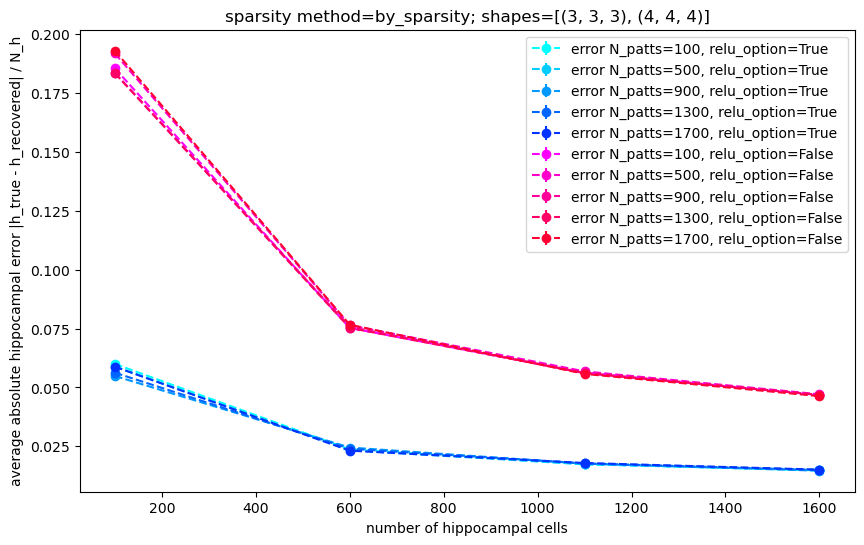

In [19]:
# err_gcpc = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# num_correct = -1 * torch.ones(len(sparsity_methods), len(N_h_list), len(Npatts_list), nruns)
# plot err vs stuff

fig, ax = plt.subplots(figsize=(10,6))
for k, relu_option in enumerate(relu_options):
    if k == 0:
        colors = color_interp("#00FFFF", "#0000FF", len(Npatts_list))
    else:
        colors = color_interp("#FF00FF", "#FF0000", len(Npatts_list))

    for p, N_p in enumerate(Npatts_list):
        avg_err = np.mean(err_gcpc[k, :, p].numpy(), axis=-1)  # mean error over runs
        std_err = np.std(err_gcpc[k, :, p].numpy(), axis=-1)  # std dev over runs

        if k == 0:
            color = "red"
        else:
            color = "blue"
        ax.errorbar(
            N_h_list,
            avg_err,
            yerr=std_err,
            fmt="ko--",
            color=colors[p],
            label=f"error N_patts={N_p}, relu_option={relu_option}",
        )
add_labels(
    ax,
    f"sparsity method=by_sparsity; shapes={shapes}",
    "number of hippocampal cells",
    "average absolute hippocampal error |h_true - h_recovered| / N_h",
)
plt.show()